### Differential abundance analyses

#### 1. Load required libraries

In [1]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("apeglm")
# install.packages("pheatmap")
library(pheatmap, warn.conflicts = F, quietly = T)
library(ggplot2, warn.conflicts = F, quietly = T)
library(limma, warn.conflicts = F, quietly = T)
library(DESeq2, warn.conflicts = F, quietly = T)
library(edgeR, warn.conflicts = F, quietly = T)
library(Glimma, warn.conflicts = F, quietly = T)
library(apeglm, warn.conflicts = F, quietly = T)


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Warning message:
“package ‘matrixStats’ was built under R version 4.1.3”

Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    

#### 2. Load data

In [2]:
# if you've already run deseq2 -- load environment
# load(".RData")

In [3]:
metadata <- read.table("map.txt", header=T, sep="\t")
row.names(metadata) <- metadata$sample_id
genecounts <- read.table("../02-STAR/homd_mapped_strict/featurecounts/read_counts.txt", header=T, sep="\t", row.names = 1)
# fix sample names gene count file
colnames(genecounts) <- gsub(x = names(genecounts), pattern = "X", replacement = "UF")  

#### 3. Format for DESeq2 analysis

In [4]:
# only compare PD to PF
metadata <- metadata[metadata$tooth_type != "PE",]
# only keep columns found in metadata
genecounts <- genecounts[, colnames(genecounts) %in% row.names(metadata)]
# reorder by metadata rownames
metadata <- metadata[order(colnames(genecounts)),]
# colnames(genecounts)
# rownames(metadata)
# create deseq object
star_results <- DESeqDataSetFromMatrix(countData = genecounts, colData = metadata, design = ~tooth_type)
# filter out any genes with fewer than 10 reads total
star_results <- star_results[rowSums(counts(star_results)) >= 10,]
star_results
# set factor level (this determines which direction the comparisions are made -- by default it's by alphabetical order)
star_results$tooth_type <- factor(star_results$tooth_type, levels=c("PD", "PF"))

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 1177152 60 
metadata(1): version
assays(1): counts
rownames(1177152): SEQF1003_00001 SEQF1003_00002 ... SEQF3050_00510
  SEQF3050_02197
rowData names(0):
colnames(60): UF106PFR UF10PD ... UF87PFR UF8PF
colData names(12): sample_id tooth_type ... Prop_Smutans Smutans_cat

#### 4. Run DESeq2

In [5]:
ptm <- proc.time()
se_star <- DESeq(star_results)
proc.time() - ptm # this takes about an hour to complete
# compute normalized counts (log2 transformed); + 1 is a count added to avoid errors during the log2 transformation: log2(0) gives an infinite number, but log2(1) is 0.
# normalized = TRUE: divide the counts by the size factors calculated by the DESeq function

norm_counts <- log2(counts(se_star, normalized = TRUE)+1)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 377862 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



    user   system  elapsed 
9589.330  266.178 6953.108 

In [6]:
# save.image()
res <- results(se_star, alpha=0.01)
# order by p value
res <- res[order(res$padj),]
paste("number of genes with adjusted p value lower than 0.01: ", sum(res$padj < 0.01, na.rm=TRUE))
summary(res)

[1] "number of genes with adjusted p value lower than 0.01:  314888"


out of 1166535 with nonzero total read count
adjusted p-value < 0.01
LFC > 0 (up)       : 90172, 7.7%
LFC < 0 (down)     : 224716, 19%
outliers [1]       : 0, 0%
low counts [2]     : 304491, 26%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [7]:
resultsNames(se_star)

[1] "Intercept"           "tooth_type_PF_vs_PD"

In [8]:
# filter out low count genes
resLFC <- lfcShrink(se_star, coef="tooth_type_PF_vs_PD", type="apeglm")
resLFC <- resLFC[order(resLFC$padj),]
paste("number of genes with adjusted p value lower than 0.01: ", sum(resLFC$padj < 0.01, na.rm=TRUE))
summary(resLFC)
# write results to file
write.table(resLFC, file="deseq_results.txt", quote=F, sep="\t")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



[1] "number of genes with adjusted p value lower than 0.01:  309805"


out of 1166535 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 162259, 14%
LFC < 0 (down)     : 335883, 29%
outliers [1]       : 0, 0%
low counts [2]     : 214068, 18%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



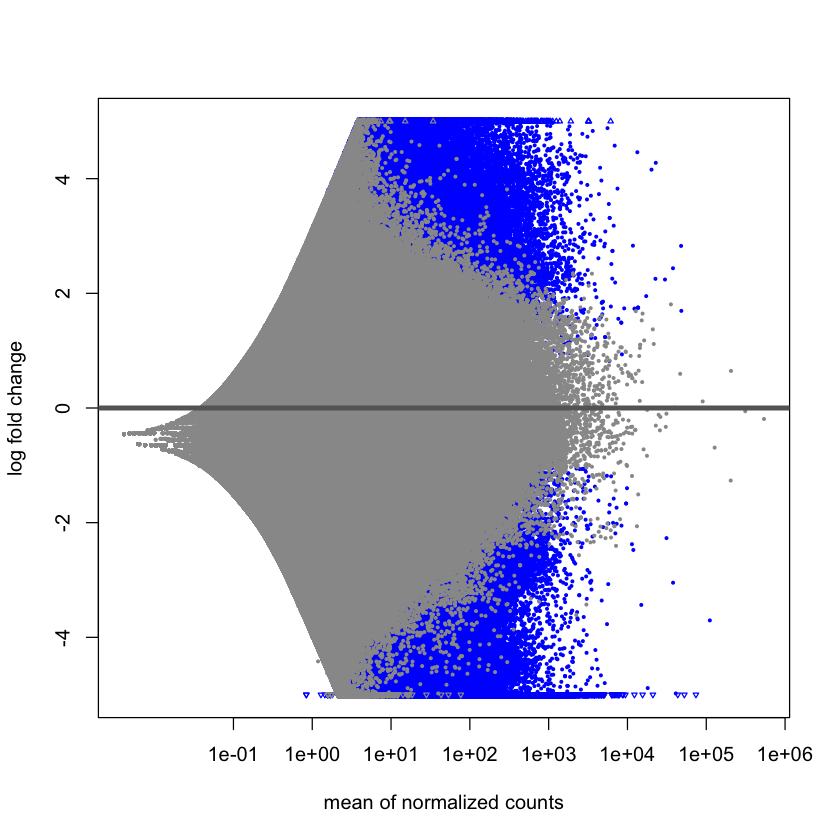

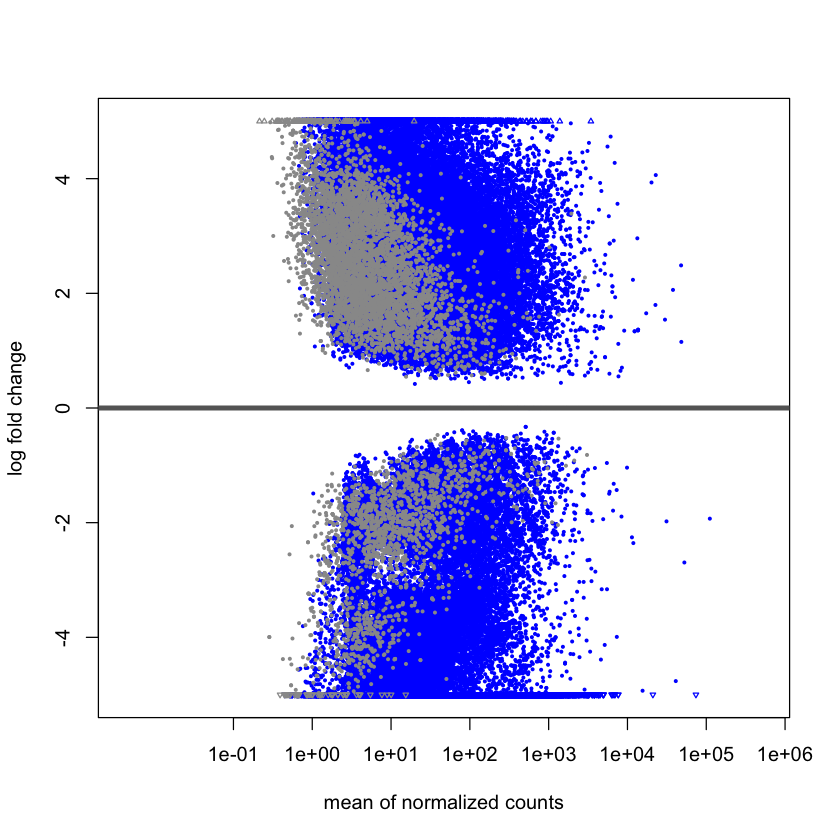

In [9]:
volcano_all <- plotMA(res, ylim=c(-5,5))
plotMA(res, ylim=c(-5,5))
volcano_flat <- plotMA(resLFC, ylim=c(-5,5))
plotMA(resLFC, ylim=c(-5,5))

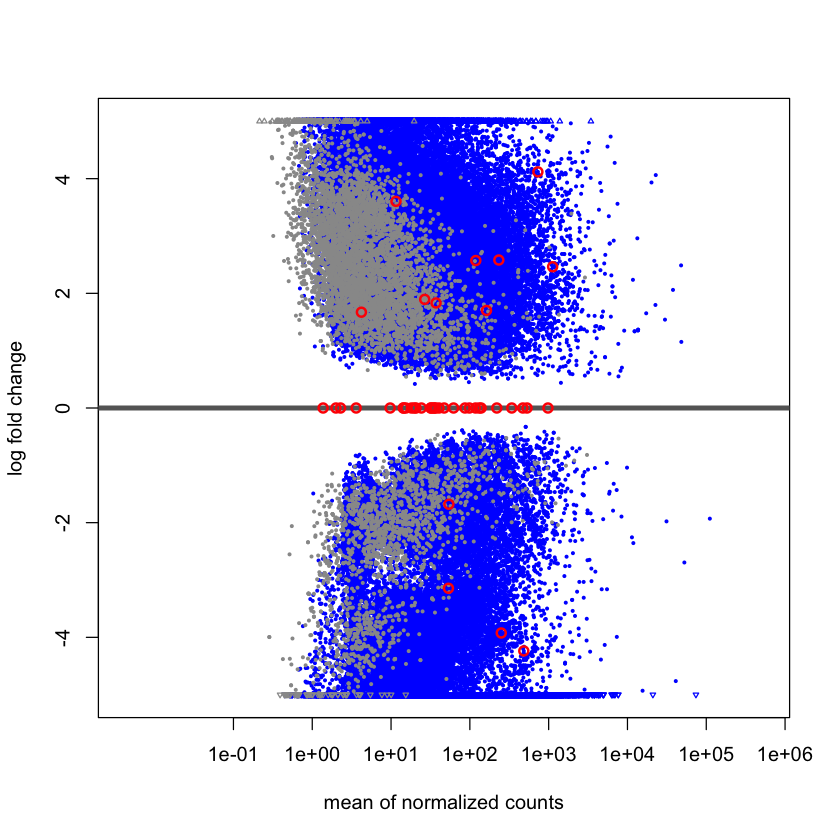

In [10]:
# test highlight some arcA genes
arcAids <- c("SEQF1018_00761","SEQF1480_00159","SEQF1480_00656","SEQF1576_01287","SEQF1600_01924","SEQF1610_00213","SEQF1654_01305","SEQF1655_01344","SEQF1693_00108","SEQF1693_02582","SEQF1701_02319","SEQF1702_01373","SEQF1766_00037","SEQF1783_00384","SEQF1847_01785","SEQF1849_00256","SEQF1849_01720","SEQF1853_01039","SEQF1854_01131","SEQF1885_01509","SEQF1933_01377","SEQF1964_00412","SEQF2007_01410","SEQF2010_01084","SEQF2016_01287","SEQF2031_01762","SEQF2222_00188","SEQF2349_01808","SEQF2391_00070","SEQF2397_00558","SEQF2444_01426","SEQF2479_01711","SEQF2573_02185","SEQF2585_01321","SEQF2587_00586","SEQF2605_00712","SEQF2609_01690","SEQF2625_00202","SEQF2705_03304","SEQF2745_02165","SEQF2748_01245","SEQF2750_02201","SEQF2751_01171","SEQF2852_00642","SEQF2976_00455")

plotMA(resLFC, ylim = c(-5,5)) 
with(subset(resLFC, rownames(resLFC) %in% arcAids), {
  points(baseMean, log2FoldChange, col = "red", cex = 1, lwd = 2)
#   text(baseMean, log2FoldChange, "SEQF1018_00761", pos = 2, col = "dodgerblue")
})

In [25]:
ccpAids <- c("SEQF1069_01475",
"SEQF1382_00569",
"SEQF3228_00476",
"SEQF3229_00458",
"SEQF3230_00471",
"SEQF3231_00464",
"SEQF3232_00486",
"SEQF3233_00455",
"SEQF3234_00481",
"SEQF3235_00479",
"SEQF3236_00471",
"SEQF3237_00458",
"SEQF3238_00477",
"SEQF3239_00486",
"SEQF3240_00474",
"SEQF3241_00454",
"SEQF3242_00470",
"SEQF3243_00473",
"SEQF3244_00411",
"SEQF3245_00471",
"SEQF3246_00469",
"SEQF3247_00491",
"SEQF3248_00472",
"SEQF3249_00444",
"SEQF3250_00488",
"SEQF3251_00485",
"SEQF3252_00467",
"SEQF3253_00481",
"SEQF3254_00471",
"SEQF3255_00437",
"SEQF3256_00470",
"SEQF3257_00482",
"SEQF3258_00447",
"SEQF3259_00483",
"SEQF3260_00477",
"SEQF3261_00464",
"SEQF3262_00442",
"SEQF3263_00460",
"SEQF3264_00466",
"SEQF3265_00458",
"SEQF3266_00477",
"SEQF3267_00473",
"SEQF3268_00448",
"SEQF3269_00471",
"SEQF3270_00460",
"SEQF3271_00468",
"SEQF3272_00481",
"SEQF3273_00406",
"SEQF3274_00409",
"SEQF3275_00452",
"SEQF3276_00479",
"SEQF3277_00471",
"SEQF3278_00476",
"SEQF3279_00474",
"SEQF3280_00474",
"SEQF3281_00475",
"SEQF3282_00476",
"SEQF3283_00474",
"SEQF3284_00483",
"SEQF3285_00473",
"SEQF3286_00472",
"SEQF3287_00476",
"SEQF3288_00439",
"SEQF3289_00479",
"SEQF3290_00499",
"SEQF3291_00472",
"SEQF3291_01746",
"SEQF3292_00570",
"SEQF3293_00473",
"SEQF3294_00474",
"SEQF3295_00475",
"SEQF3296_00481",
"SEQF3297_00436",
"SEQF3298_00409",
"SEQF3299_00443",
"SEQF3300_00436",
"SEQF3301_00471",
"SEQF3302_00466",
"SEQF3303_01447",
"SEQF3304_00565",
"SEQF3305_01386",
"SEQF3306_00046",
"SEQF3307_01525",
"SEQF3308_00344",
"SEQF3309_00058",
"SEQF3310_01479",
"SEQF3311_01684",
"SEQF3312_00426",
"SEQF3313_00027",
"SEQF3314_01424",
"SEQF3315_01187",
"SEQF3316_00262",
"SEQF3317_00588",
"SEQF3318_00224",
"SEQF3319_01379",
"SEQF3320_00424",
"SEQF3321_00269",
"SEQF3322_00507",
"SEQF3323_00422",
"SEQF3324_00355",
"SEQF3325_01339",
"SEQF3326_01502",
"SEQF3327_01064",
"SEQF3328_01670",
"SEQF3329_00809",
"SEQF3330_00728",
"SEQF3331_00295",
"SEQF3332_01266",
"SEQF3333_01192",
"SEQF3334_01087",
"SEQF3335_00908",
"SEQF3336_00312",
"SEQF3337_00556",
"SEQF3338_01484",
"SEQF3339_01801",
"SEQF3340_01472",
"SEQF3341_00734",
"SEQF3342_00895",
"SEQF3343_01493",
"SEQF3344_01385",
"SEQF3345_01018",
"SEQF3346_00281",
"SEQF3347_00968",
"SEQF3348_01081",
"SEQF3349_00460",
"SEQF3350_00255",
"SEQF3351_01594",
"SEQF3352_00083",
"SEQF3353_00160",
"SEQF3354_00324",
"SEQF3355_00060",
"SEQF3356_00445",
"SEQF3357_00960",
"SEQF3358_01120",
"SEQF3359_00655",
"SEQF3360_01408",
"SEQF3361_00956",
"SEQF3362_01416",
"SEQF3363_01455",
"SEQF3364_01364",
"SEQF3365_01374",
"SEQF3366_01430",
"SEQF3367_01424",
"SEQF3368_00783",
"SEQF3369_01445",
"SEQF3370_01424",
"SEQF3371_01374",
"SEQF3372_01594",
"SEQF3373_01341",
"SEQF3373_01436",
"SEQF3374_00491",
"SEQF3375_01557",
"SEQF3376_00670",
"SEQF3377_01355",
"SEQF3378_01126",
"SEQF3379_00597",
"SEQF3380_00760",
"SEQF3381_00557",
"SEQF3382_01109",
"SEQF3383_00481",
"SEQF3384_01171",
"SEQF3385_00915",
"SEQF3385_01564",
"SEQF3386_00550",
"SEQF3386_01340",
"SEQF3387_01836",
"SEQF3388_00993",
"SEQF3389_00443",
"SEQF3390_01719",
"SEQF3391_01449",
"SEQF3392_00161",
"SEQF3393_01841",
"SEQF3394_00092",
"SEQF3395_00124",
"SEQF3396_01811",
"SEQF3397_00198",
"SEQF3398_00706",
"SEQF3399_01258",
"SEQF3400_01356",
"SEQF3401_01026",
"SEQF3402_01900",
"SEQF3403_00611",
"SEQF3404_01275",
"SEQF3405_01546",
"SEQF3406_00288",
"SEQF3407_01640",
"SEQF3408_01625",
"SEQF3409_00563",
"SEQF3410_01758",
"SEQF3411_01306",
"SEQF3412_01451",
"SEQF3413_00569",
"SEQF3414_01209",
"SEQF3415_00292",
"SEQF3416_00582",
"SEQF3417_00575",
"SEQF3418_01457",
"SEQF3419_01387",
"SEQF3420_00196",
"SEQF3421_01767",
"SEQF3422_00435",
"SEQF3423_00437",
"SEQF3424_00159",
"SEQF3425_00436",
"SEQF3426_01766",
"SEQF3428_00788",
"SEQF3429_00491",
"SEQF3430_01197",
"SEQF3431_01351",
"SEQF3432_01687",
"SEQF3433_01391",
"SEQF3434_01224",
"SEQF3435_01324",
"SEQF3436_00472",
"SEQF3437_01632",
"SEQF3438_00824",
"SEQF3439_01282",
"SEQF3440_01261",
"SEQF3441_01653",
"SEQF3442_00959",
"SEQF3443_01508",
"SEQF3444_00813",
"SEQF3445_01073",
"SEQF3446_00507",
"SEQF3447_00800",
"SEQF3448_00509",
"SEQF3449_00577",
"SEQF3450_00833",
"SEQF3451_01704",
"SEQF3452_00814",
"SEQF3453_00783",
"SEQF3454_01127",
"SEQF3455_01209",
"SEQF3456_00155",
"SEQF3457_00961",
"SEQF3458_01687",
"SEQF3459_01104",
"SEQF3460_00528",
"SEQF3461_01580",
"SEQF3462_01214",
"SEQF3463_01199",
"SEQF3463_01548",
"SEQF3464_01151",
"SEQF3465_01156",
"SEQF3466_00636",
"SEQF3467_01035",
"SEQF3469_01403",
"SEQF3470_01446",
"SEQF3471_00575",
"SEQF3472_01760",
"SEQF3473_00744",
"SEQF3474_01200")

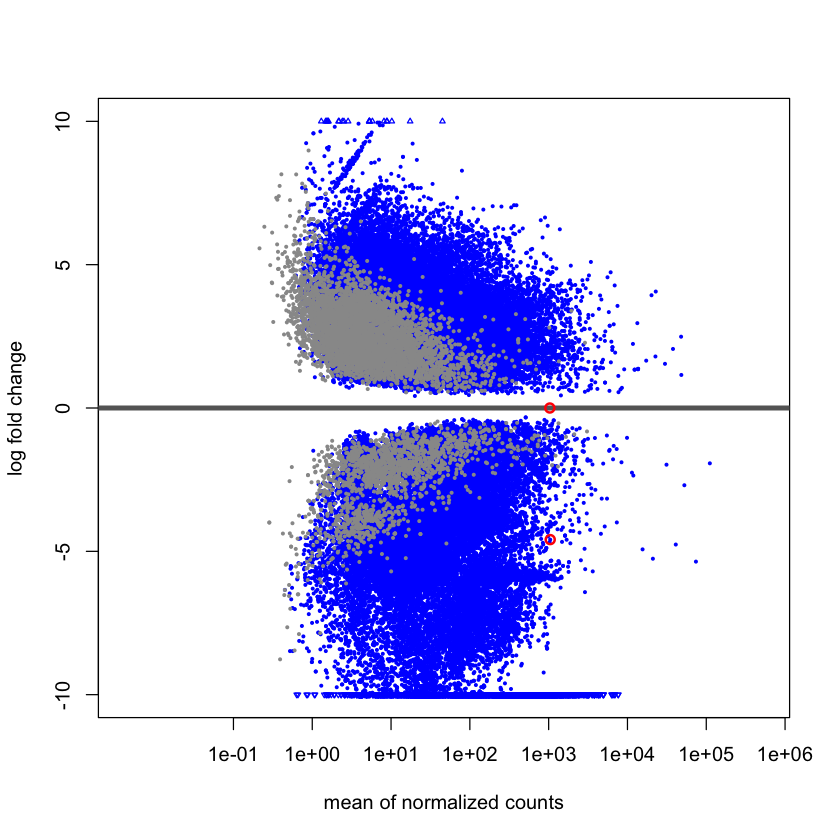

In [28]:
plotMA(resLFC, ylim = c(-10,10)) 
with(subset(resLFC, rownames(resLFC) %in% ccpAids), {
  points(baseMean, log2FoldChange, col = "red", cex = 1, lwd = 2)
#   text(baseMean, log2FoldChange, "SEQF1018_00761", pos = 2, col = "dodgerblue")
})

In [11]:
# transform for visualizations
vld <- vst(se_star)

pdf 
  2

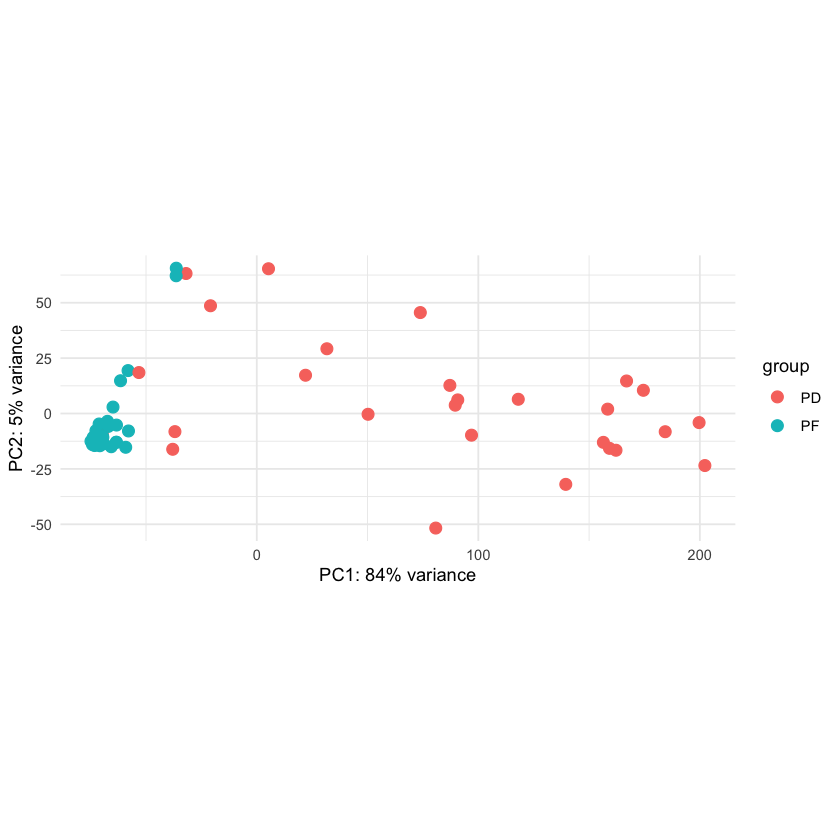

In [12]:
#Get 25 top varying genes
topVarGenes <- head(order(rowVars(assay(vld)), decreasing=TRUE), 25)
 
#make a subset of the log transformed counts for just the top 25 varying genes
top25Counts <- assay(vld)[topVarGenes,]
write.csv(top25Counts, file="top25counts.vld.csv", quote=FALSE)
 
#PLOT PCA
#PCA using top 500 varying genes
pdf("pca_pdvpf.pdf")
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()
dev.off()
plotPCA(vld, intgroup=c("tooth_type"), ntop=500) + theme_minimal()

pdf 
  2

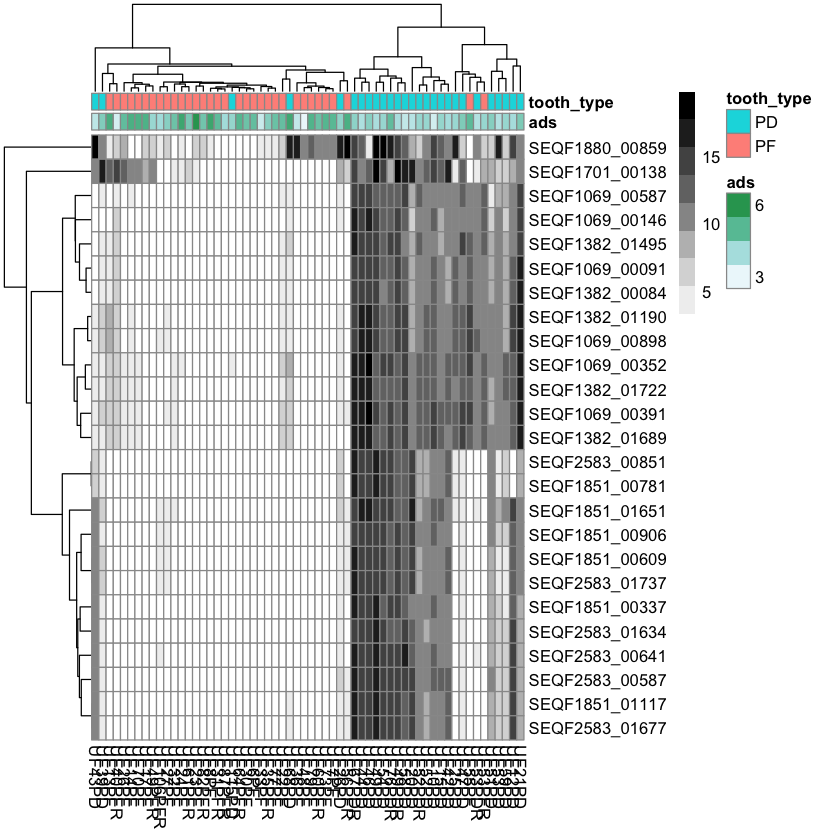

In [13]:
df <- as.data.frame(colData(vld)[,c("ads_nmol_min_mg_of_protein","tooth_type")])
df$ads_nmol_min_mg_of_protein <- log2(as.numeric(df$ads_nmol_min_mg_of_protein))
colnames(df) <- c("ads", "tooth_type")

save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}
library(RColorBrewer)
x <- pheatmap(top25Counts, annotation_col = df, color = brewer.pal(9, "Greys"))
save_pheatmap_pdf(x, "heatmap_pdvpf.pdf")

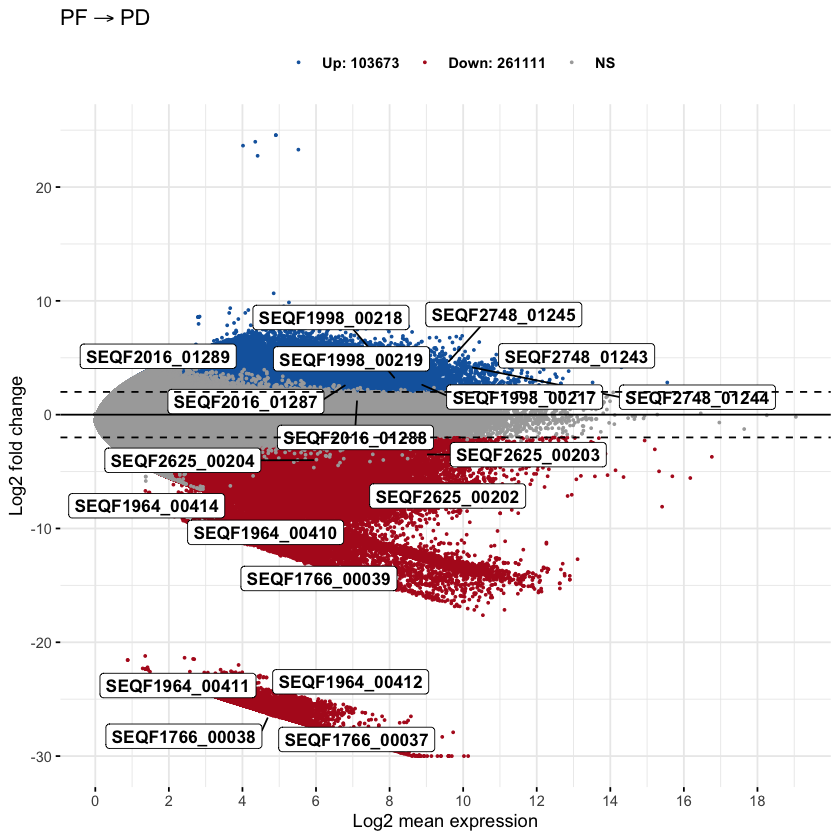

In [14]:
# install.packages("ggpubr")
library(ggpubr)
options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#1465AC", "#B31B21", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 0,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   label.select = c("SEQF2748_01243", "SEQF2748_01244", "SEQF2748_01245", "SEQF2016_01287", "SEQF2016_01288", "SEQF2016_01289", "SEQF1998_00217", "SEQF1998_00218", "SEQF1998_00219", "SEQF1964_00410", "SEQF1964_00411", "SEQF1964_00412", "SEQF1964_00414", "SEQF2625_00202", "SEQF2625_00203", "SEQF2625_00204", "SEQF1766_00037", "SEQF1766_00038", "SEQF1766_00039"),
   ggtheme = ggplot2::theme_minimal())
p
# pdf("volcanoPlot_community.pdf")
# p
# dev.off()

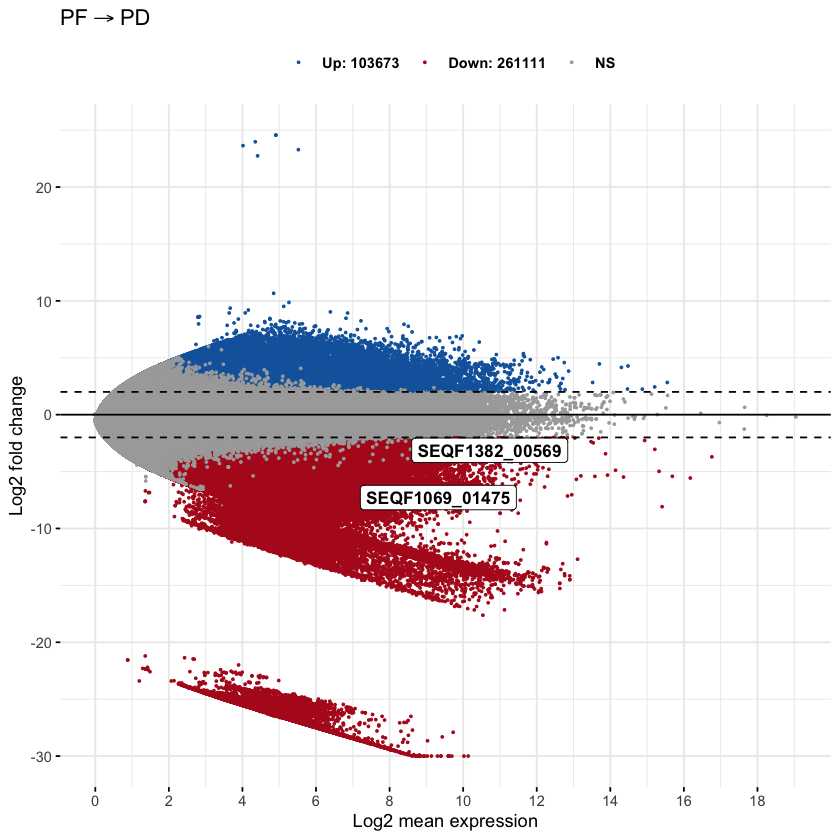

In [29]:
# ccpA mutans upregulated in disease?b
# install.packages("ggpubr")
library(ggpubr)
options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#1465AC", "#B31B21", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 0,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   label.select = ccpAids,
   ggtheme = ggplot2::theme_minimal())
p
# pdf("volcanoPlot_community.pdf")
# p
# dev.off()

In [46]:
# other genes (for testing!)
otherids <- c("SEQF1367_00308",
"SEQF1478_02548",
"SEQF1881_00458",
"SEQF1881_00459",
"SEQF1881_01152",
"SEQF1897_02390",
"SEQF1897_02392",
"SEQF1897_02394",
"SEQF1897_02395",
"SEQF1899_01134",
"SEQF1967_01534",
"SEQF1967_01535",
"SEQF1967_01537",
"SEQF1967_01538",
"SEQF1967_01540",
"SEQF1967_01541",
"SEQF1967_01542",
"SEQF1967_02055",
"SEQF2065_01266",
"SEQF2072_00147",
"SEQF2074_00451",
"SEQF2075_01924",
"SEQF2141_00594",
"SEQF2345_01926",
"SEQF2346_01661",
"SEQF2346_01662",
"SEQF2346_01663",
"SEQF2346_01665",
"SEQF2346_01667",
"SEQF2346_01668",
"SEQF2348_00267",
"SEQF2444_01147",
"SEQF2748_00472",
"SEQF2760_02246",
"SEQF2761_02500",
"SEQF2816_00218",
"SEQF2841_01931",
"SEQF2917_00340",
"SEQF2920_00211",
"SEQF2976_01873",
"SEQF2976_01875",
"SEQF2976_01877",
"SEQF3025_00165")

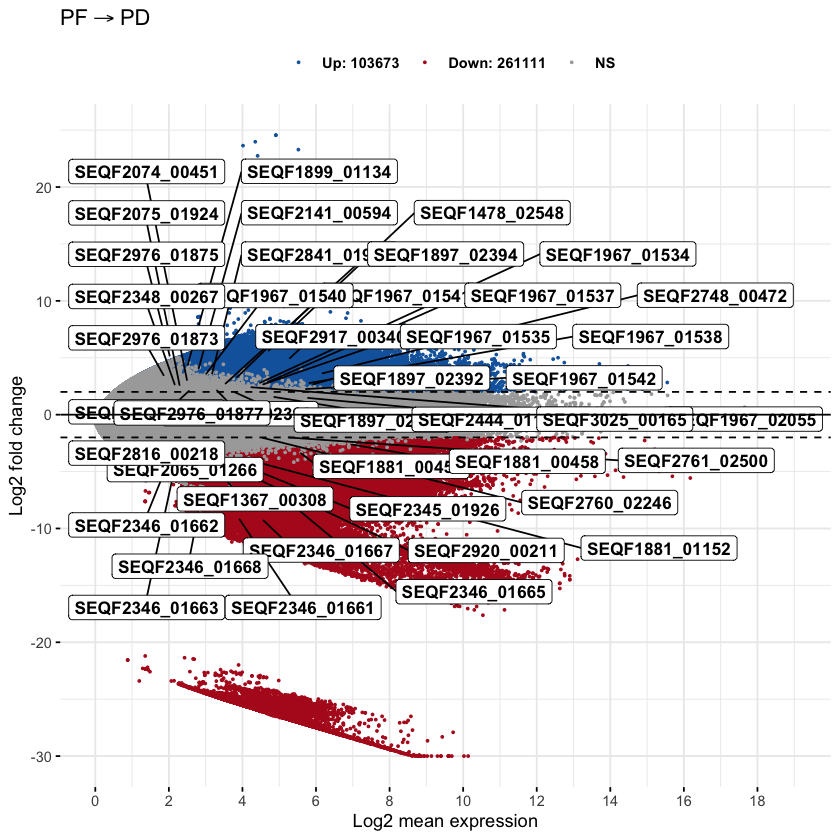

In [47]:
# other genes (for testing!)
options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#1465AC", "#B31B21", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 0,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   label.select = otherids,
   ggtheme = ggplot2::theme_minimal())
p

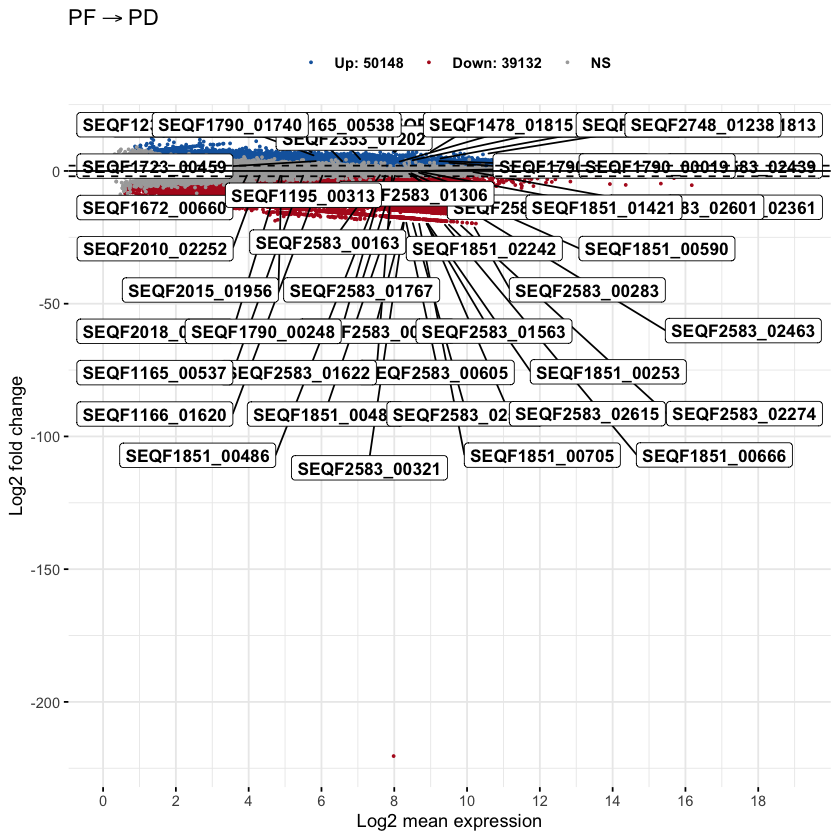

In [15]:
# get labels for top up and top down regulated genes
upreg <- res[res$log2FoldChange > 4,]
downreg <- res[res$log2FoldChange < -4,]
# rank by p value, get top 5
upregname <- row.names(upreg[rank(upreg$padj) <= 25,])
# bottom 10
downregname <- row.names(downreg[rank(downreg$padj) <= 25,])
regnames <- c(upregname, downregname)

options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(resLFC, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#1465AC", "#B31B21", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 0,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   label.select = regnames,
   ggtheme = ggplot2::theme_minimal())
p

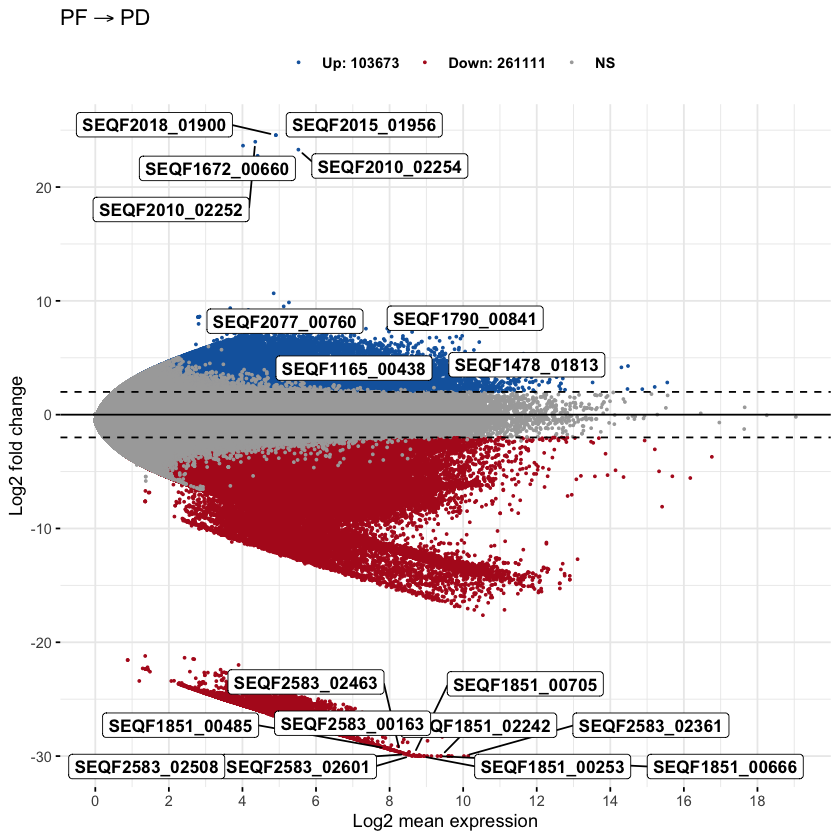

In [16]:
# get labels for top up and top down regulated genes
upreg <- res[res$log2FoldChange > 2,]
downreg <- res[res$log2FoldChange < -2,]

# rank by p value, get top 10
upregname <- row.names(upreg[rank(upreg$padj) <= 10,])
# bottom 10
downregname <- row.names(downreg[rank(downreg$padj) <= 10,])
regnames <- c(upregname, downregname)

options(ggrepel.max.overlaps = Inf)
p <- ggmaplot(res, main = expression("PF" %->% "PD"),
   fdr = 0.05, fc = 4, size = 0.4,
   palette = c("#1465AC", "#B31B21", "darkgray"),
   genenames = as.vector(row.names(res)),
   legend = "top", top = 0,
   font.label = c("bold", 11),
   font.legend = "bold",
   font.main = "bold",
   label.rectangle = T,
   label.select = regnames,
   ggtheme = ggplot2::theme_minimal())
p

In [17]:
write.table(p$data, "volcanoPlot_community.dat.txt", quote = F, sep = "\t") 

In [18]:
library(ape)
library(phytools)
library(phyloseq)
seqtab <- read.table("../10-normalize/sequence_table.filt.txt", header=T, row.names=1)
tax <- read.table("../10-normalize/taxonomy_bac.txt", header=F, row.names=1, sep="\t")
tree <- read.tree("../10-normalize/RAxML_bestTree.ref.tre")
tree.root <- midpoint.root(tree)
map <- read.table("../03-diff_abundance/map.txt", sep="\t", header=T, row.names=1)
ps.dat <- phyloseq(otu_table(seqtab, taxa_are_rows=T), sample_data(map), tax_table(as.matrix(tax)), tree.root)
ps.dat


Attaching package: ‘ape’


The following object is masked from ‘package:ggpubr’:

    rotate


Loading required package: maps


Attaching package: ‘phyloseq’


The following object is masked from ‘package:SummarizedExperiment’:

    distance


The following object is masked from ‘package:Biobase’:

    sampleNames


The following object is masked from ‘package:GenomicRanges’:

    distance


The following object is masked from ‘package:IRanges’:

    distance




phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3113 taxa and 60 samples ]
sample_data() Sample Data:       [ 60 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 3113 taxa by 11 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3113 tips and 3112 internal nodes ]

In [19]:
install.packages("forcats")
library(forcats)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



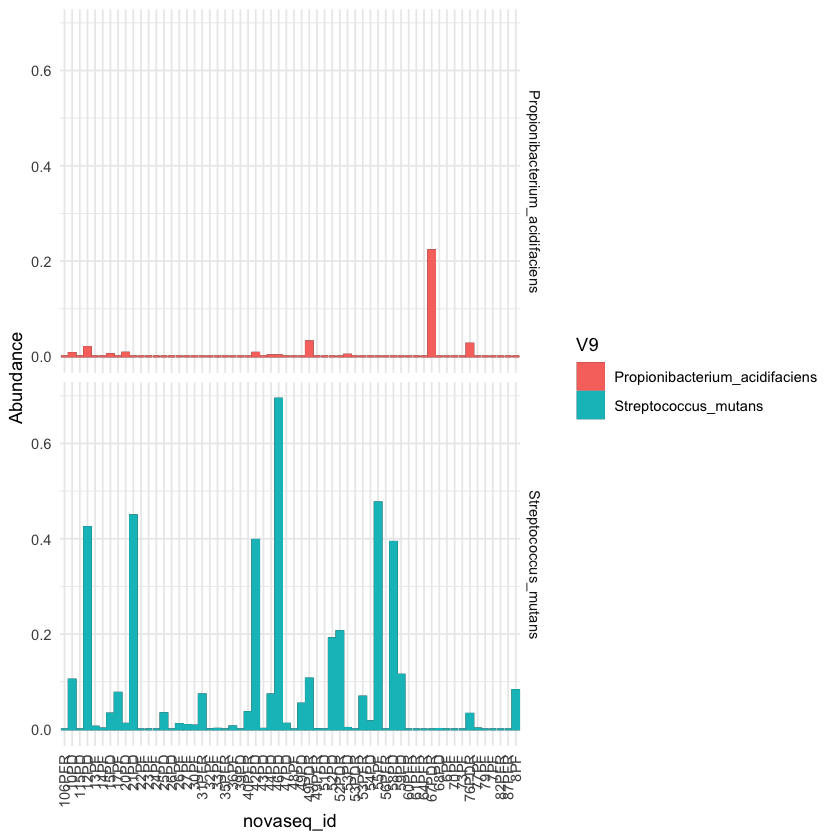

pdf 
  2

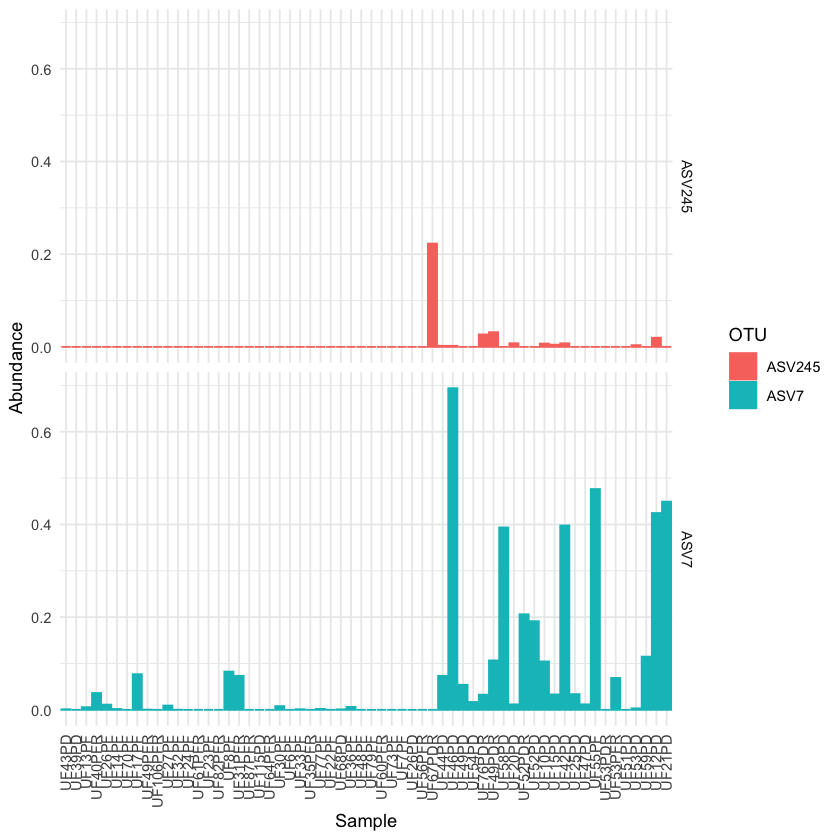

In [20]:
order <- colnames(top25Counts[,x$tree_col[["order"]]])
# order
relabund <- transform_sample_counts(ps.dat, function(x) x/sum(x))
sub <- subset_taxa(relabund, V9=="Streptococcus_mutans" | V9=="Propionibacterium_acidifaciens")
sub <- subset_samples(sub, tooth_type != "PE")
glom <- tax_glom(sub, taxrank=rank_names(sub)[8])

# by sample
taxbargrp <- plot_bar(glom, "novaseq_id", fill="V9", facet_grid="V9") + geom_bar(aes(color=V9, fill=V9), stat="identity", position="stack") 
taxbargrp + theme_minimal() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) 
taxbargrp$data$Sample <- factor(taxbargrp$data$Sample, levels = order)
# taxbargrp$data
# ordered by heatmap
ggplot(taxbargrp$data, aes(x=Sample, y=Abundance, levels=Sample)) + 
    geom_bar(aes(color=OTU, fill=OTU), stat="identity", position="stack") + 
    facet_grid(rows = vars(OTU)) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
pdf("barplot_smutans_pacid_heatmap_order.pdf")
ggplot(taxbargrp$data, aes(x=Sample, y=Abundance, levels=Sample)) + 
    geom_bar(aes(color=OTU, fill=OTU), stat="identity", position="stack") + 
    facet_grid(rows = vars(OTU)) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
dev.off()